## Synchronised Chaos

### Implementing the transmitter and receiver

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import optimize

In [ ]:
# Parameters of a chaotic Lorenz system
r, s, b = (28, 10, 8/3)

# Setting the time step and total simulation time
dt = 0.001
steps = 80000

# Initial conditions for transmitter
state_transmitter = np.empty((steps + 1, 3))  # Need one more for the initial values
state_transmitter[0] = (0, 1.0, 1.05) 

# Initial conditions for receiver
state_receiver = np.empty((steps + 1, 3)) 
state_receiver[0] = (0.1, 3.0, 0.05)  # If the system synchronises, any initial values work

# Time array
t = np.linspace(0, steps*dt, steps+1)   

# Message signal sample
message = np.sin(60*t)

# Defining the transmitter Lorenz system
def transmitter(initial_transmitter):
    x, y, z = initial_transmitter   # Initial conditions unpacked as a tuple
    dx_dt = s*(y-x)
    dy_dt = r*x - y - x*z
    dz_dt = x*y - b*z
    return np.array([dx_dt, dy_dt, dz_dt])

# Defining the receiver Lorenz system
def receiver(initial_receiver, input_signal):
    x, y, z = initial_receiver 
    dx_dt = s*(y-x) 
    dy_dt = r*input_signal - y - input_signal*z
    dz_dt = input_signal*y - b*z
    return np.array([dx_dt, dy_dt, dz_dt])

# 4th Order Runge Kutta method (RK4)
def RK4(dt, function, state, *args):
    k1 = function(state, *args)
    k2 = function(state + (dt*k1)/2, *args)
    k3 = function(state + (dt*k2)/2, *args)
    k4 = function(state + dt*k3, *args)
    return state + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)

# Use RK4 to numerically solve for transmitter system
for i in range(steps):
    state_transmitter[i + 1] = RK4(dt, transmitter, state_transmitter[i])

# Generating the mask to encrypt the signal
x_values = state_transmitter[:, 0]  
masked_values = x_values + message

# Use RK4 to numerically solve for receiver system
for i in range(steps):
    state_receiver[i + 1] = RK4(dt, receiver, state_receiver[i], masked_values[i])

# Regenerating the mask to decrypt the signal
xr_values = state_receiver[:, 0]
decrypted_values = masked_values - xr_values
error = np.abs(decrypted_values - message) # Error should decrease exponentially with time

# For calculating RMSE in decryption
def RMSE(error):
    return np.sqrt(np.mean(error**2))

In [ ]:
# For observing a range of interest
start_view = 24000
end_view = 30000
t_view = t[start_view:end_view]
m_view = message[start_view:end_view]
x_view = x_values[start_view:end_view]
xr_view = xr_values[start_view:end_view]
masked_view = masked_values[start_view:end_view]
decrypted_view = decrypted_values[start_view:end_view]

# Plotting the chaotic mask and message signal
ax = plt.figure().add_subplot()
ax.plot(t_view, x_view, label="mask")
ax.set_xlabel("Time step")
ax.set_ylabel("Masking Values")
ax.set_title('Masking values vs Time')
ax.scatter(t_view, m_view, label="message", c="orange", s=1)
ax.legend()

# Plotting the masked signal
ax = plt.figure().add_subplot()
ax.plot(t_view, masked_view)
ax.set_xlabel("Time step")
ax.set_ylabel("Masked Values")
ax.set_title('Masked values vs Time')

# Plotting the retrieved signal
ax = plt.figure().add_subplot()
ax.plot(t_view, decrypted_view, label="decrypted message")
ax.set_xlabel("Time step")
ax.set_ylabel("Decrypted Values")
ax.set_title('Decrypted Values vs Time')
ax.scatter(t_view, m_view, label="original message", c="orange", s=1)

plt.tight_layout()
plt.show()


In [ ]:
# Plotting the chaotic mask and message signal
ax = plt.figure().add_subplot()
ax.plot(t_view, x_view, label="transmitter")
ax.set_xlabel("Time step")
ax.set_ylabel("Masking Values")
ax.set_title('Masking values vs Time')
ax.scatter(t_view, xr_view, label="receiver", c="orange", s=1)
ax.legend()

In [ ]:
# Example exponential function
def exponential(t, a, b):
    return a*np.exp(-b*t)

# Fit curve
popt, pcov = optimize.curve_fit(exponential, t, error)

# Compute fitted values
fitted_error = exponential(t, *popt)

# Compute R^2
residuals = error - fitted_error
ss_res = np.sum(residuals**2)
ss_tot = np.sum((error - np.mean(error))**2)
r_squared = 1 - (ss_res / ss_tot)

ax = plt.figure().add_subplot()
ax.scatter(t, error, label="Data", s=1)
ax.plot(t, fitted_error, label=f"Exponential Fit", linewidth=2, c="orange")

ax.set_xlabel("Time step")
ax.set_ylabel("Error Values")
ax.set_title("Error between receiver and transmitter")
ax.legend()

# Display relevant parameters
print("R-squared =", round(r_squared, 3))

### Processing audio files

In [ ]:
from scipy.io.wavfile import read
from scipy.io.wavfile import write

We will work with WAV files (Waveform Audio File format) for audio masking, as they can be easily processed using packages from scipy. In WAV files, audio signals are broken down into "samples", which are numerical values representing the relative amplitude of the audio signal at a given point in time. The following information need to be obtained by reading the WAV file:
- Sample data. These encode information about the audio signal that we want to process.
- Sample rate (Hz). This tells us how many times per second an analog signal is measured. 
- Number of samples. This tells us how many time steps we need to mask each sample in the audio.
- Bit depth. This gives the range of values of signal amplitudes. 
- Number of channels. Usually 1 for mono and 2 for stereo channels.

In [ ]:
# Read a WAV file
sample_rate, data = read("rickroll.wav")
print(f"There are {len(data)} samples in the audio file")
print(f"The sample rate is {sample_rate} Hz")
print(f"The bit depth is {data.dtype}") 
print(f"The number of channels is {len(data.shape)}") 

Having obtained the relevant information, we can first proceed with visualising the audio signals as waveforms. The x-axis is time in seconds and the y-axis is amplitude of the audio signal at any given point in time. 

Note that for audio processing, the steps variable at the start of the notebook needs to be adjusted to match the number of samples in the audio file. In particular, $steps = samples - 1$. The current notebook does not reflect this as the transmitter and receiver systems were used for other purposes once audio processing was completed.

In [ ]:
# Scale to obtain time in seconds
time = np.arange(len(data)) / sample_rate  

# Separate the sample data into their respective channels
left_channel = data[:steps+1, 0]
right_channel = data[:steps+1, 1]

# Plotting the waveform
plt.figure(figsize=(14, 4))
plt.plot(time[:steps], left_channel[:steps], label="Left Channel")
plt.plot(time[:steps], right_channel[:steps], label="Right Channel")

plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Stereo Waveform")
plt.legend()
plt.show()

Before proceeding with encryption, some data cleaning needs to be done. The transmitter can only encode 1 channel a time so let us just select the left channel. For a 16-bit file there are $2^{16}$ possible values of amplitudes, corresponding to a range of $-2^{15} \leq ampplitude \leq 2^{15} - 1$, since 0 is also a possible value. We will need to normalise this amplitude, that is to scale it to $-1 \leq ampplitude \leq 1$ so that the mask can be effective. Finally, since the mask is implemented in time steps, a suitable scaling factor is needed to convert it into seconds.

In [ ]:
amplitude = 2**15   
sound_waves = left_channel / amplitude # To normalise the amplitude for a 16 bit file
simulation_seconds = t/(sample_rate*dt) # To scale the time steps into seconds

# Plotting the processed audio waveform
plt.figure(figsize=(14, 4))
plt.plot(simulation_seconds, sound_waves)
plt.xlabel("Time/s")
plt.ylabel("Amplitude")
plt.title("Left Stereo Waveform")

# Encrpyting the audio file
masked_sound = x_values + sound_waves

# Plotting the chaotic mask and message signal
ax = plt.figure().add_subplot()
ax.plot(simulation_seconds, x_values, label="mask")
ax.set_xlabel("Time/s")
ax.set_ylabel("Masking Values")
ax.set_title('Masking values vs Time')
ax.scatter(simulation_seconds, sound_waves, label="signal", c="orange", s=1)
ax.legend()

# Plotting the masked signal
ax = plt.figure().add_subplot()
ax.plot(simulation_seconds, masked_sound)
ax.set_xlabel("Time/s")
ax.set_ylabel("Masked Values")
ax.set_title('Masked values vs Time')

plt.show()

In [ ]:
# To observe a segment of the masking

start_sound = 30000
end_sound = 40000

ax = plt.figure().add_subplot()
ax.plot(simulation_seconds[start_sound:end_sound], x_values[start_sound:end_sound], label="mask")
ax.set_xlabel("Time/s")
ax.set_ylabel("Masking Values")
ax.set_title('Masking values vs Time')
ax.scatter(simulation_seconds[start_sound:end_sound], sound_waves[start_sound:end_sound], label="signal", c="orange", s=1)
ax.legend()

ax = plt.figure().add_subplot()
ax.plot(simulation_seconds[start_sound:end_sound], masked_sound[start_sound:end_sound])
ax.set_xlabel("Time/s")
ax.set_ylabel("Masked Values")
ax.set_title('Masked values vs Time')

plt.show()

The audio signal is now masked under the chaotic signal and is output by the transmitter. We will now input this message signal into the receiver for decryption. 

In [ ]:
# Use RK4 to numerically solve for receiver system
for i in range(steps):
    state_receiver[i + 1] = RK4(dt, receiver, state_receiver[i], masked_sound[i])

In [ ]:
# Regenerating the mask to decrypt the signal
xs_values = state_receiver[:, 0]
decrypt_sound = masked_sound - xs_values

# Plotting the retrieved signal
ax = plt.figure().add_subplot()
ax.plot(simulation_seconds, decrypt_sound, label="decrypted signal", alpha=.55)
ax.set_xlabel("Time/s")
ax.set_ylabel("Decrypted Values")
ax.set_title('Decrypted Values vs Time')
ax.scatter(simulation_seconds, sound_waves, label="original signal", c="orange", s=1)
ax.legend()

# To observe a segment of the decrypion
ax = plt.figure().add_subplot()
ax.plot(simulation_seconds[start_sound:end_sound], decrypt_sound[start_sound:end_sound], label="decrypted signal")
ax.set_xlabel("Time/s")
ax.set_ylabel("Decrypted Values")
ax.set_title('Decrypted Values vs Time')
ax.scatter(simulation_seconds[start_sound:end_sound], sound_waves[start_sound:end_sound], label="original signal", c="orange", s=1)
ax.legend()

plt.show()

For a measure of how well the decryption has been performed, we calculate the RMSE values. We also plot the difference between the decrypted signal and the original signal over time. 

In [ ]:
# Calculate RMSE in decryption
error_sound = np.abs(decrypt_sound - sound_waves)
rms_error_sound = RMSE(error_sound)
print(f"The RMSE in decryption is {rms_error_sound}")

# Plotting the error
ax = plt.figure().add_subplot()
ax.plot(simulation_seconds, error)
ax.set_xlabel("Time/s")
ax.set_ylabel("Error Values")
ax.set_title('Error between receiver and transmitter')

After confirming that encryption and decryption are successful, we can now ouput the respective audio files by writing them. We have to scale the amplitudes back to their original values so that the signals are audible.

In [ ]:
# Writing the output file
y1_int16 = (masked_sound * amplitude).astype(np.int16)
y2_int16 = (decrypt_sound * amplitude).astype(np.int16)

write("encrypted.wav", sample_rate, y1_int16)
write("decrypted.wav", sample_rate, y2_int16)

# Image encryption Trial

## Method 1: Splitting the image's RGB values as RGBRGBRGB

C:\Users\User\AppData\Local\Temp\ipykernel_16344\3103930291.py:15: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(ar1.reshape(height,width,3),'RGB')


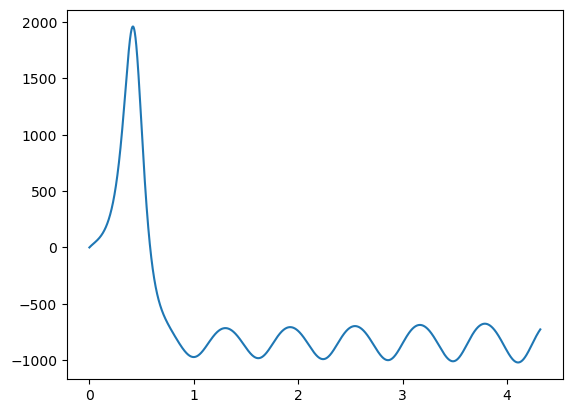

In [45]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

im=Image.open(r'C:\Undergraduate_NUS\Semester 1\SP2273\Lorenz encryption\SP2273_Group_project_Chaos_Sync\97-973734_instagram-clipart-picsart-png-instagram-logo-100x100-png.jpg')
def unwrapper(image):
    img_array=np.asarray(image)
    #flattening the array
    return img_array.flatten()

#Stringing everything together
#now the flattened array is basically (rgb_rgb_rgb.....rgb)*width*height
def wrapper(ar1,height,width):
    #my array has shape (height,width,3)
    return Image.fromarray(ar1.reshape(height,width,3),'RGB')
# Parameters of a chaotic Lorenz system
r, s, b = (28, 10, 8/3)

# Setting the time step and total simulation time
dt = 0.0001
steps = im.size[1]*im.size[0]*3-1

# Initial conditions for transmitter
state_transmitter = np.empty((steps + 1, 3))  # Need one more for the initial values
state_transmitter[0] = (0, 1.0, 1.05) 

# Initial conditions for receiver
state_receiver = np.empty((steps + 1, 3)) 
state_receiver[0] = (0.1, 1.0, 1.05)  # If the system synchronises, any initial values work

t = np.linspace(0, steps*dt, steps+1)   # time array

# Message signal sample
a = 1.0   # Modulate amplitude, if needed
k=100.0
#m = np.sin(60*t) + np.cos(40*t) + np.sin(20*np.pi*t) + np.cos(30*t)
m=unwrapper(im)

# Defining the transmitter Lorenz system
def transmitter(initial_transmitter):
    x, y, z = initial_transmitter   # Initial conditions unpacked as a tuple
    dx_dt = s*(k*y-x)
    dy_dt = r*x/k - y - x*z/k
    dz_dt = x*y/k - b*z
    return np.array([dx_dt, dy_dt, dz_dt])

# Defining the receiver Lorenz system
def receiver(initial_receiver, input_signal):
    x, y, z = initial_receiver 
    dx_dt = s*(k*y-x) 
    dy_dt = r*input_signal/k - y - input_signal*z/k
    dz_dt = input_signal*y/k - b*z
    return np.array([dx_dt, dy_dt, dz_dt])

# 4th Order Runge Kutta method (RK4)
def RK4(dt, function, state, *args):
    k1 = function(state, *args)
    k2 = function(state + (dt*k1)/2, *args)
    k3 = function(state + (dt*k2)/2, *args)
    k4 = function(state + dt*k3, *args)
    return state + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)

# Use RK4 to numerically solve for transmitter system
for i in range(steps):
    state_transmitter[i + 1] = RK4(dt, transmitter, state_transmitter[i])

# Generating the mask to encrypt the signal
x_values = state_transmitter[:, 0]  
masked_values = x_values + m

#this masked_values are now sent over to the receiver. If they were intercepted and undone, this is the output:
masked_output=np.clip(np.floor(masked_values), 0, 255).astype(np.uint8)
image1=wrapper(masked_output,im.size[1],im.size[0])
image1.save("encrypted_image_1.jpeg", "jpeg")

# Use RK4 to numerically solve for receiver system
for i in range(steps):
    state_receiver[i + 1] = RK4(dt, receiver, state_receiver[i], masked_values[i])



# Regenerating the mask to decrypt the signal
xr_values = state_receiver[:, 0]


decrypt = (masked_values - xr_values)*1
new_dec=np.clip(np.floor(decrypt), 0, 255).astype(np.uint8)
error = np.abs(xr_values - x_values) # Error should decrease exponentially with time
image=wrapper(new_dec,im.size[1],im.size[0])
image.save("decrypted_image_1.jpeg", "jpeg")
#GRAPHING initial message and decrypt
plt.plot(t,x_values)
#plt.plot(t,new_dec)

# Method 1A- adding transients(works well)

C:\Users\User\AppData\Local\Temp\ipykernel_18000\3979270790.py:15: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(ar1.reshape(height,width,3),'RGB')


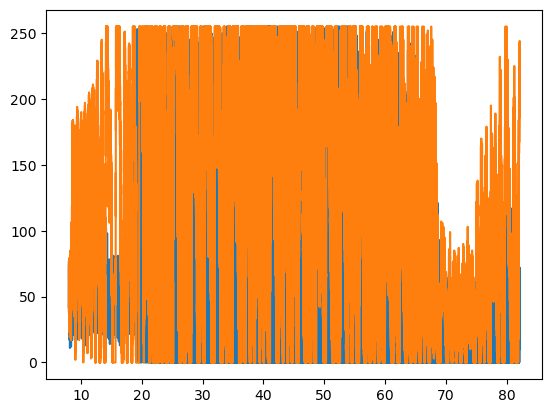

In [11]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
garbage=80000
im=Image.open(r'Screenshot 2025-10-31 115047.jpg')
def unwrapper(image):
    img_array=np.asarray(image)
    #flattening the array
    return img_array.flatten()

#Stringing everything together
#now the flattened array is basically (rgb_rgb_rgb.....rgb)*width*height
def wrapper(ar1,height,width):
    #my array has shape (height,width,3)
    return Image.fromarray(ar1.reshape(height,width,3),'RGB')
# Parameters of a chaotic Lorenz system
r, s, b = (28, 10, 8/3)

# Setting the time step and total simulation time
dt = 0.0001
steps = im.size[1]*im.size[0]*3-1+garbage

# Initial conditions for transmitter
state_transmitter = np.empty((steps + 1, 3))  # Need one more for the initial values
state_transmitter[0] = (0, 1.0, 1.05) 

# Initial conditions for receiver
state_receiver = np.empty((steps + 1, 3)) 
state_receiver[0] = (0.1, 1.0, 1.05)  # If the system synchronises, any initial values work

t = np.linspace(0, steps*dt, steps+1)   # time array

# Message signal sample
a = 1.0   # Modulate amplitude, if needed
k = 100.0 #mask scaling value
#m = np.sin(60*t) + np.cos(40*t) + np.sin(20*np.pi*t) + np.cos(30*t)
m1=unwrapper(im)
m = np.concatenate((np.zeros(garbage), m1))

# Defining the transmitter Lorenz system
def transmitter(initial_transmitter):
    x, y, z = initial_transmitter   # Initial conditions unpacked as a tuple
    dx_dt = s*(k*y-x)
    dy_dt = r*x/k - y - x*z/k
    dz_dt = x*y/k - b*z
    return np.array([dx_dt, dy_dt, dz_dt])

# Defining the receiver Lorenz system
def receiver(initial_receiver, input_signal):
    x, y, z = initial_receiver 
    dx_dt = s*(k*y-x) 
    dy_dt = r*input_signal/k - y - input_signal*z/k
    dz_dt = input_signal*y/k - b*z
    return np.array([dx_dt, dy_dt, dz_dt])

# 4th Order Runge Kutta method (RK4)
def RK4(dt, function, state, *args):
    k1 = function(state, *args)
    k2 = function(state + (dt*k1)/2, *args)
    k3 = function(state + (dt*k2)/2, *args)
    k4 = function(state + dt*k3, *args)
    return state + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)

# Use RK4 to numerically solve for transmitter system
for i in range(steps):
    state_transmitter[i + 1] = RK4(dt, transmitter, state_transmitter[i])

# Generating the mask to encrypt the signal
x_values = state_transmitter[:, 0]  
masked_values = x_values + m

#this masked_values are now sent over to the receiver. If they were intercepted and undone, this is the output:
masked_output=np.clip(masked_values[garbage:], 0, 255).astype(np.uint8)
image1=wrapper(masked_output,im.size[1],im.size[0])
image1.save("encrypted_image.jpeg", "jpeg")

# Use RK4 to numerically solve for receiver system
for i in range(steps):
    state_receiver[i + 1] = RK4(dt, receiver, state_receiver[i], masked_values[i])



# Regenerating the mask to decrypt the signal
xr_values = state_receiver[:, 0]


decrypt = (masked_values - xr_values)*1
new_dec=np.clip(decrypt[garbage:], 0, 255).astype(np.uint8)
error = np.abs(xr_values - x_values) # Error should decrease exponentially with time
image=wrapper(new_dec,im.size[1],im.size[0])
image.save("decrypted_image.jpeg", "jpeg")
#GRAPHING initial message and decrypt
plt.plot(t[garbage:],m1)
plt.plot(t[garbage:],new_dec)

# Method 2: Split the reds seperately, then the blues, then the greens (doesn't work as well)

(120, 120)
YASSS QUEEN
The root mean square error is:0.6271843302518899


C:\Users\User\AppData\Local\Temp\ipykernel_16344\3704698552.py:103: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image=Image.fromarray(image_signal,'RGB')
C:\Users\User\AppData\Local\Temp\ipykernel_16344\3704698552.py:105: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image1=Image.fromarray(wrapperv2(m1.astype(np.uint8),im.size[1],im.size[0]),'RGB')
C:\Users\User\AppData\Local\Temp\ipykernel_16344\3704698552.py:107: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image2=Image.fromarray(wrapperv2(np.clip(masked_values*a, 0, 255).astype(np.uint8),im.size[1],im.size[0]),'RGB')


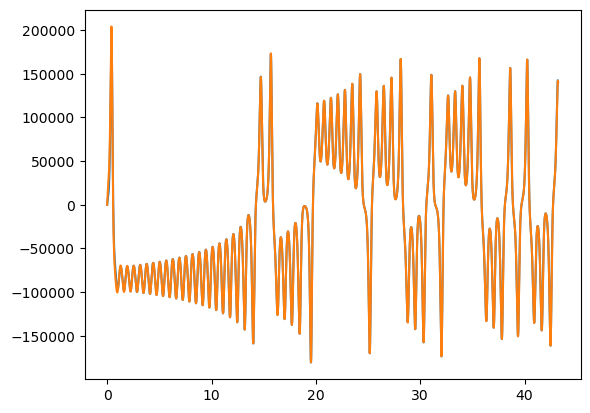

In [38]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt


im=Image.open(r'C:\Undergraduate_NUS\Semester 1\SP2273\Lorenz encryption\SP2273_Group_project_Chaos_Sync\97-973734_instagram-clipart-picsart-png-instagram-logo-100x100-png.jpg')
print(im.size)
def unwrapperv2(image=im):
    img_array=np.asarray(image)
    print('YASSS QUEEN')
    #composing the 3 different channels
    R=img_array[:,:,0]
    G=img_array[:,:,1]
    B=img_array[:,:,2]
    output=np.concatenate((R,G,B),axis= None)
    return output.flatten()

    

#Stringing everything together
#now the flattened array is basically (r_r_r_r_)*width*height+(g_g_g_g_)*width*height+(b_b_b_b_)*width*height
def wrapperv2(ar1,height,width):
    R=ar1[:height*width].reshape(height,width)
    G=ar1[height*width:2*height*width].reshape(height,width)
    B=ar1[2*height*width:].reshape(height,width)
    new_array=np.stack((R, G, B), axis=-1)

    #my array has shape (height,width,3)
    return new_array

#image=wrapperv2(unwrapperv2(),im.size[1],im.size[0])
#image.save("output_image_v3.jpg", "jpeg")

# Parameters of a chaotic Lorenz system
r, s, b = (28, 10, 8/3)

# Setting the time step and total simulation time
dt = 0.001
steps = im.size[1]*im.size[0]*3-1

# Initial conditions for transmitter
state_transmitter = np.empty((steps + 1, 3))  # Need one more for the initial values
state_transmitter[0] = (0, 1.0, 1.05) 

# Initial conditions for receiver
state_receiver = np.empty((steps + 1, 3)) 
state_receiver[0] = (0.1, 3.0, 0.05)  # If the system synchronises, any initial values work

t = np.linspace(0, steps*dt, steps+1)   # time array

# Message signal sample
a = 1.0 # Modulate amplitude, if needed
k = 10000.0 #k is x scale factor
'''m = np.sin(60*t) + np.cos(40*t) + np.sin(20*np.pi*t) + np.cos(30*t)'''
m1=unwrapperv2().astype(float)
m=m1/a

# Defining the transmitter Lorenz system
def transmitter(initial_transmitter):
    x, y, z = initial_transmitter   # Initial conditions unpacked as a tuple
    dx_dt = s*(k*y-x)
    dy_dt = r*x/k - y - x*z/k
    dz_dt = x*y/k - b*z
    return np.array([dx_dt, dy_dt, dz_dt])

# Defining the receiver Lorenz system
def receiver(initial_receiver, input_signal):
    x, y, z = initial_receiver 
    dx_dt = s*(k*y-x) 
    dy_dt = r*input_signal/k - y - input_signal*z/k
    dz_dt = input_signal*y/k - b*z
    return np.array([dx_dt, dy_dt, dz_dt])

# 4th Order Runge Kutta method (RK4)
def RK4(dt, function, state, *args):
    k1 = function(state, *args)
    k2 = function(state + (dt*k1)/2, *args)
    k3 = function(state + (dt*k2)/2, *args)
    k4 = function(state + dt*k3, *args)
    return state + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)

# Use RK4 to numerically solve for transmitter system
for i in range(steps):
    state_transmitter[i + 1] = RK4(dt, transmitter, state_transmitter[i])

# Generating the mask to encrypt the signal
x_values = state_transmitter[:, 0]  
masked_values = x_values + m
# Use RK4 to numerically solve for receiver system
for i in range(steps):
    state_receiver[i + 1] = RK4(dt, receiver, state_receiver[i], masked_values[i])



# Regenerating the mask to decrypt the signal
xr_values = state_receiver[:, 0]
decrypt = (masked_values - xr_values)

new_dec=np.clip(decrypt*a, 0, 255).astype(np.uint8)

error = np.abs(xr_values - x_values) # Error should decrease exponentially with time
image_signal=wrapperv2(new_dec,im.size[1],im.size[0])
image=Image.fromarray(image_signal,'RGB')
image.save("reconstructed_image11.jpg", "jpeg")
image1=Image.fromarray(wrapperv2(m1.astype(np.uint8),im.size[1],im.size[0]),'RGB')
image1.save("test.jpg", "jpeg")
image2=Image.fromarray(wrapperv2(np.clip(masked_values*a, 0, 255).astype(np.uint8),im.size[1],im.size[0]),'RGB')
image2.save("encrypted_image.jpg", "jpeg")
#metrics
RMSE=np.sqrt(np.sum((m-new_dec)**2))/m.size
print(f'The root mean square error is:{RMSE}')

#Graphing
#plt.plot(t,m)
#plt.plot(t,decrypt)
#plt.plot(t,masked_values)
plt.plot(t,x_values)
plt.plot(t,xr_values)

# 2A- giving the image signal some transients.(doesn't work as well)

(120, 120)
YASSS QUEEN


C:\Users\User\AppData\Local\Temp\ipykernel_16344\3423111212.py:104: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image=Image.fromarray(image_signal,'RGB')
C:\Users\User\AppData\Local\Temp\ipykernel_16344\3423111212.py:106: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image1=Image.fromarray(wrapperv2(m1.astype(np.uint8),im.size[1],im.size[0]),'RGB')
C:\Users\User\AppData\Local\Temp\ipykernel_16344\3423111212.py:108: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image2=Image.fromarray(wrapperv2(np.clip(masked_values[garbage:]*a, 0, 255).astype(np.uint8),im.size[1],im.size[0]),'RGB')


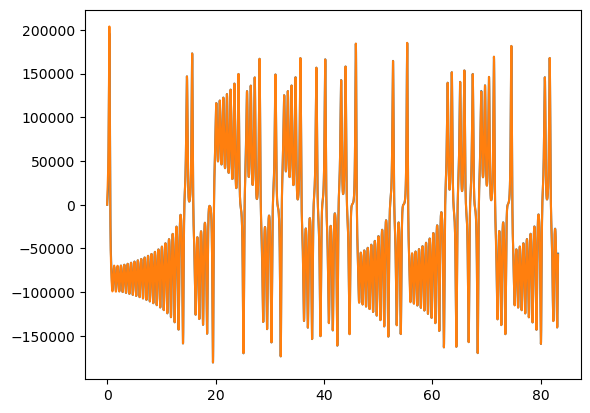

In [37]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

garbage=int(40000)
im=Image.open(r'C:\Undergraduate_NUS\Semester 1\SP2273\Lorenz encryption\SP2273_Group_project_Chaos_Sync\97-973734_instagram-clipart-picsart-png-instagram-logo-100x100-png.jpg')
print(im.size)
def unwrapperv2(image=im):
    img_array=np.asarray(image)
    print('YASSS QUEEN')
    #composing the 3 different channels
    R=img_array[:,:,0]
    G=img_array[:,:,1]
    B=img_array[:,:,2]
    output=np.concatenate((R,G,B),axis= None)
    return output.flatten()

    

#Stringing everything together
#now the flattened array is basically (r_r_r_r_)*width*height+(g_g_g_g_)*width*height+(b_b_b_b_)*width*height
def wrapperv2(ar1,height,width):
    R=ar1[:height*width].reshape(height,width)
    G=ar1[height*width:2*height*width].reshape(height,width)
    B=ar1[2*height*width:].reshape(height,width)
    new_array=np.stack((R, G, B), axis=-1)

    #my array has shape (height,width,3)
    return new_array

#image=wrapperv2(unwrapperv2(),im.size[1],im.size[0])
#image.save("output_image_v3.jpg", "jpeg")

# Parameters of a chaotic Lorenz system
r, s, b = (28, 10, 8/3)

# Setting the time step and total simulation time
dt = 0.001
steps = im.size[1]*im.size[0]*3-1+garbage

# Initial conditions for transmitter
state_transmitter = np.empty((steps + 1, 3))  # Need one more for the initial values
state_transmitter[0] = (0, 1.0, 1.05) 

# Initial conditions for receiver
state_receiver = np.empty((steps + 1, 3)) 
state_receiver[0] = (0.1, 3.0, 0.05)  # If the system synchronises, any initial values work

t = np.linspace(0, steps*dt, steps+1)   # time array

# Message signal sample
a = 1.0 # Modulate amplitude, if needed
k = 10000.0 #k is x scale factor
'''m = np.sin(60*t) + np.cos(40*t) + np.sin(20*np.pi*t) + np.cos(30*t)'''
m1=unwrapperv2().astype(float)
m = np.concatenate((np.zeros(garbage), m1/a))


# Defining the transmitter Lorenz system
def transmitter(initial_transmitter):
    x, y, z = initial_transmitter   # Initial conditions unpacked as a tuple
    dx_dt = s*(k*y-x)
    dy_dt = r*x/k - y - x*z/k
    dz_dt = x*y/k - b*z
    return np.array([dx_dt, dy_dt, dz_dt])

# Defining the receiver Lorenz system
def receiver(initial_receiver, input_signal):
    x, y, z = initial_receiver 
    dx_dt = s*(k*y-x) 
    dy_dt = r*input_signal/k - y - input_signal*z/k
    dz_dt = input_signal*y/k - b*z
    return np.array([dx_dt, dy_dt, dz_dt])

# 4th Order Runge Kutta method (RK4)
def RK4(dt, function, state, *args):
    k1 = function(state, *args)
    k2 = function(state + (dt*k1)/2, *args)
    k3 = function(state + (dt*k2)/2, *args)
    k4 = function(state + dt*k3, *args)
    return state + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)

# Use RK4 to numerically solve for transmitter system
for i in range(steps):
    state_transmitter[i + 1] = RK4(dt, transmitter, state_transmitter[i])

# Generating the mask to encrypt the signal
x_values = state_transmitter[:, 0]  
masked_values = x_values + m
# Use RK4 to numerically solve for receiver system
for i in range(steps):
    state_receiver[i + 1] = RK4(dt, receiver, state_receiver[i], masked_values[i])



# Regenerating the mask to decrypt the signal
xr_values = state_receiver[:, 0]
decrypt = (masked_values - xr_values)

new_dec=np.clip(a*decrypt[garbage:], 0, 255).astype(np.uint8)

error = np.abs(xr_values - x_values) # Error should decrease exponentially with time
image_signal=wrapperv2(new_dec,im.size[1],im.size[0])
image=Image.fromarray(image_signal,'RGB')
image.save("reconstructed_image.jpg", "jpeg")
image1=Image.fromarray(wrapperv2(m1.astype(np.uint8),im.size[1],im.size[0]),'RGB')
image1.save("test.jpg", "jpeg")
image2=Image.fromarray(wrapperv2(np.clip(masked_values[garbage:]*a, 0, 255).astype(np.uint8),im.size[1],im.size[0]),'RGB')
image2.save("encrypted_image.jpg", "jpeg")
#metrics
#RMSE=np.sqrt(np.sum((m-new_dec)**2))/m.size
#print(f'The root mean square error is:{RMSE}')

#Graphing
#plt.plot(t,m)
#plt.plot(t,decrypt)
#plt.plot(t,masked_values)
plt.plot(t,x_values)
plt.plot(t,xr_values)

## From Zs

### Investigating inputs
- Amplitude (Need to reconcile with theory)
- Length of simulation (work in progress)
- Frequency of sin function (graph needs explanation)
- Different test functions (output needs explanation)

Current issues: 
For amplitude, RMSE alone might not be meaningful as smaller message amplitude results in smaller RMSE values but graphically depicts a poorer fit to the decryted signal.

For length of simulation, the code works for an initial run but subsequent runs will output constant valus. The transmitter and receiver implementation code needs to be run for the code to work again.

No idea why the graphs for RMSE vs frequency and the respective input functions behave these ways. 

In [ ]:
# Changing length of simulation
length_errors = []
test_points = range(0, steps + 1, 100)
for L in test_points:
    xr_values_length = state_receiver[:L+1, 0]
    decrypt_test_length = masked_values[:L+1] - xr_values_length
    error_length = np.abs(decrypt_test_length - message[:L+1])
    length_errors.append(RMSE(error_length))

lengths = [i for i in range(len(length_errors))]

ax = plt.figure().add_subplot()
ax.plot(lengths, length_errors)
ax.set_xlabel("Length of simulation")
ax.set_ylabel("RMSE values")
ax.set_title('RMSE values vs Simulation time')

plt.show()

In [ ]:
freq_errors = []

# Test frequencies from 1 Hz to 100 Hz
frequencies = range(1, 101)

for f in frequencies:
    # Generate message signal for this frequency
    freq_function = np.sin(f*t)
    mask_test_freq = freq_function + x_values

    # Initialize receiver state
    state_receiver_freq = np.empty((steps + 1, 3))
    state_receiver_freq[0] = (0.1, 3.0, 0.05)

    # Integrate receiver for full steps
    for j in range(steps):
        state_receiver_freq[j + 1] = RK4(dt, receiver, state_receiver_freq[j], mask_test_freq[j])

    # Decrypt and compute RMSE
    xr_values_freq = state_receiver_freq[:, 0]
    decrypt_test_freq = mask_test_freq - xr_values_freq
    error_freq = np.abs(decrypt_test_freq - freq_function)
    freq_errors.append(RMSE(error_freq))

ax = plt.figure().add_subplot()
ax.plot(frequencies, freq_errors)
ax.set_xlabel("Frequencies")
ax.set_ylabel("RMSE values")
ax.set_title('RMSE values vs Frequency')
plt.show()

In [ ]:
amp_errors = []
amplitudes = [i/50 for i in range(1, 101)]  # Amplitude scaling factors

for a in amplitudes:
    # Generate message signal for this amplitude
    amp_function = a * np.sin(60*t)
    mask_test_amp = amp_function + x_values

    # Initialize receiver state
    state_receiver_amp = np.empty((steps + 1, 3))
    state_receiver_amp[0] = (0.1, 3.0, 0.05)

    # Integrate receiver
    for j in range(steps):
        state_receiver_amp[j + 1] = RK4(dt, receiver, state_receiver_amp[j], mask_test_amp[j])

    # Decrypt and compute normalized RMSE
    xr_values_amp = state_receiver_amp[:, 0]
    decrypt_test_amp = mask_test_amp - xr_values_amp
    error = np.abs(decrypt_test_amp - amp_function)
    rms_error_amp = RMSE(error) / (np.max(amp_function) - np.min(amp_function))
    amp_errors.append(rms_error_amp)

# Plot RMSE vs amplitude
ax = plt.figure().add_subplot()
ax.plot(amplitudes, amp_errors)
ax.set_xlabel("Amplitudes")
ax.set_ylabel("RMSE values")
ax.set_title('RMSE values vs Amplitudes')
plt.show()
